# Импорт либ

In [5]:
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from PIL import Image

import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm 

import warnings

warnings.filterwarnings("ignore")

In [7]:
sns.set_theme()
pal = sns.set_palette([
    "#FF6347", "#4682B4", "#8A2BE2", "#FFD700", "#32CD32",
    "#FF4500", "#1E90FF", "#FF1493", "#00FA9A", "#FFDAB9",
    "#6A5ACD", "#FF8C00", "#ADFF2F", "#20B2AA", "#FF69B4",
    "#7B68EE", "#FFB6C1", "#00BFFF", "#F08080", "#DDA0DD"
])

# Гипер-параметры

In [8]:
BASE_DATA_DIR = '/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data' 
TRAIN_IMG_DIR = os.path.join(BASE_DATA_DIR, 'img_train')
TEST_IMG_DIR = os.path.join(BASE_DATA_DIR, 'img_test')
TRAIN_CSV_PATH = os.path.join(BASE_DATA_DIR, 'train_answers.csv')
CATEGORIES_CSV_PATH = os.path.join(BASE_DATA_DIR, 'activity_categories.csv')
SUBMISSION_CSV_PATH = 'submission.csv'
BEST_MODEL_PATH = 'best_model.pth'

BATCH_SIZE = 48
BATCH_SIZE_2 = 32
NUM_EPOCHS = 50
NUM_EPOCHS_2 = 100
LEARNING_RATE = 0.01

# Починка меток 

In [9]:
PRESENT_CLASS_IDS = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]
NUM_CLASSES = len(PRESENT_CLASS_IDS) 

# Создаем словарь для маппинга оригинальных ID в новые ID (0 до NUM_CLASSES-1)
original_to_dense_map = {original_id: dense_id for dense_id, original_id in enumerate(PRESENT_CLASS_IDS)}

# Создаем обратный словарь для маппинга новых ID обратно в оригинальные (понадобится для вывода)
dense_to_original_map = {dense_id: original_id for dense_id, original_id in enumerate(PRESENT_CLASS_IDS)}

categories_df = pd.read_csv(CATEGORIES_CSV_PATH)
categories_map = categories_df.set_index('id')['category'].to_dict()

## Базовый Dataset

* **path** - исходное месторасположение всех изображений;
* **transform** - преобразования, в частности **transforms.Compose**;
* **trainFlag** - флаг **train/test** *(True/False)*;
* **file_list** - список типа *(label : int, img_path : str)*.

In [10]:
class ImageDataset(Dataset):
    def __init__(self, path, transform):
        
        self.path = path
        self.transform = transform

    def __len__(self):
        
        return len(self.file_list)

    def __getitem__(self, idx):

        file_path = os.path.join(self.path, self.file_list[idx][1])

        with Image.open(file_path) as img:
            img = self.transform(img)
            return (img, self.file_list[idx][0])

## Transforms

### Аугментация **1.0**

In [ ]:
transform1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 15]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor()
])

transformSimple = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor()
])

### Аугментация **AntiHor**

In [ ]:
transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 10]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor()
])

### Аугментация **Norm1.0**

In [ ]:
transform3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 10]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

transformSimple2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

### Аугментация **Norm2.0**

In [3]:
transform4 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomRotation([10, 20]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.45, 1.5],
        hue=[-.1, .1]
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

NameError: name 'transforms' is not defined

### Аугментация **NormCorrected&PDF**

In [11]:
class CustomRandomRotation:
    def __init__(self, func, **kwrgs):
        
        self.function = {
            'normal' : np.random.normal,
            'chi2' : stats.chi2.rvs
        }[func]

        self.params = kwrgs

    def __call__(self, img):
        
        angle = self.function(**self.params)
        
        return transforms.functional.rotate(img, angle)

Суть в том, чтобы сделать акцент на величины с большей частотностью желаемого распределения, ниже представлен пример с **chi2** распредлением : в данном случае больший акцент на значениях промежутка **3-12**

<Axes: ylabel='Count'>

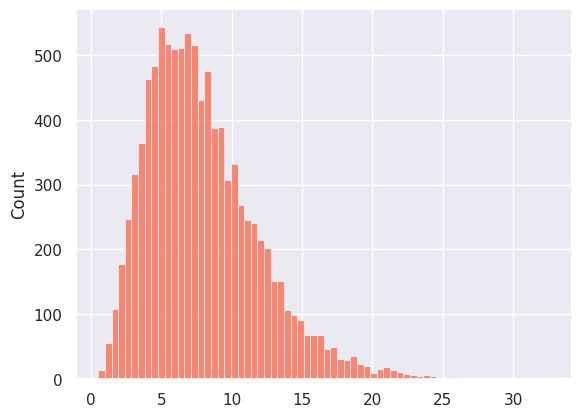

In [12]:
sns.histplot(x=stats.chi2.rvs(8, size=10000))

#### Вычисление **MEAN**, **STD**

In [13]:
path = TRAIN_IMG_DIR

sum_pixels = torch.zeros((3,))
count = 0

sum_squares = torch.zeros((3,))

transform = transforms.Compose([transforms.ToTensor()])

for filename in os.listdir(path):
    img_path = os.path.join(path, filename)
    with Image.open(img_path) as img:
        img_tensor = transform(img)

        sum_pixels += img_tensor.mean(dim=(1, 2))
        count += 1

        sum_squares += (img_tensor ** 2).mean(dim=(1, 2))

mean = sum_pixels / count
std = (sum_squares / count - mean ** 2) ** 0.5

mean, std

KeyboardInterrupt: 

In [14]:
transform5 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.5),
    CustomRandomRotation('chi2', df=8),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=0,
        contrast=.2,
        saturation=[.45, 1.5],
        hue=[-.05, .05]
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=tensor([0.4674, 0.4497, 0.4122]), 
        std=tensor([0.2739, 0.2694, 0.2740])) # (tensor([0.4674, 0.4497, 0.4122]), tensor([0.2739, 0.2694, 0.2740]))
]) 

transformSimple3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=tensor([0.4674, 0.4497, 0.4122]), 
        std=tensor([0.2739, 0.2694, 0.2740])) 
])

## Train-test-split

Идея в том, чтобы тосавать и разбивать **список путей к изображениям**, а после по ним уже получать соотв. данные

In [15]:
def train_test(path, path_answers, test_size=0.2, train_trans=None, test_trans=None, batch_size=64):

    file_list = os.listdir(path)
    answers_df = pd.read_csv(path_answers)

    target_dict = answers_df.set_index('img_id')['target_feature'].to_dict()

    objs = []
    for file in file_list:
        img_id = int(os.path.splitext(file)[0])
        target = target_dict.get(img_id)
        if target is not None and target in original_to_dense_map:
            dense_target = original_to_dense_map[target] 
            objs.append((dense_target, file)) 
            
    train_files, test_files = train_test_split(
    objs, test_size=test_size, random_state=42)

    train_dataset = ImageDataset(path, train_trans)
    train_dataset.file_list = train_files
    
    test_dataset = ImageDataset(path, test_trans)
    test_dataset.file_list = test_files
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_dataloader, test_dataloader

In [16]:
def plot_images(data_loader):
    first_batch = next(iter(data_loader))

    images = first_batch[0]
    labels = first_batch[1]

    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))

    classesByInLabels = pd.read_csv(CATEGORIES_CSV_PATH)

    for y in range(2):
        for x in range(6):
            axes[y, x].imshow(images[12 // (y + 1) - (x + 1)].permute(1, 2, 0))
            axes[y, x].set(xticks=[])
            axes[y, x].set(yticks=[])
            axes[y, x].set_title(classesByInLabels[classesByInLabels['id'] == int(labels[12 // (y + 1) - (x + 1)])]['category'].iloc[0])
            
    plt.plot()

In [25]:
train_dataloader, test_dataloader = train_test(
    TRAIN_IMG_DIR, 
    TRAIN_CSV_PATH,
    train_trans=transform1,
    test_trans=transformSimple,
    batch_size=BATCH_SIZE)

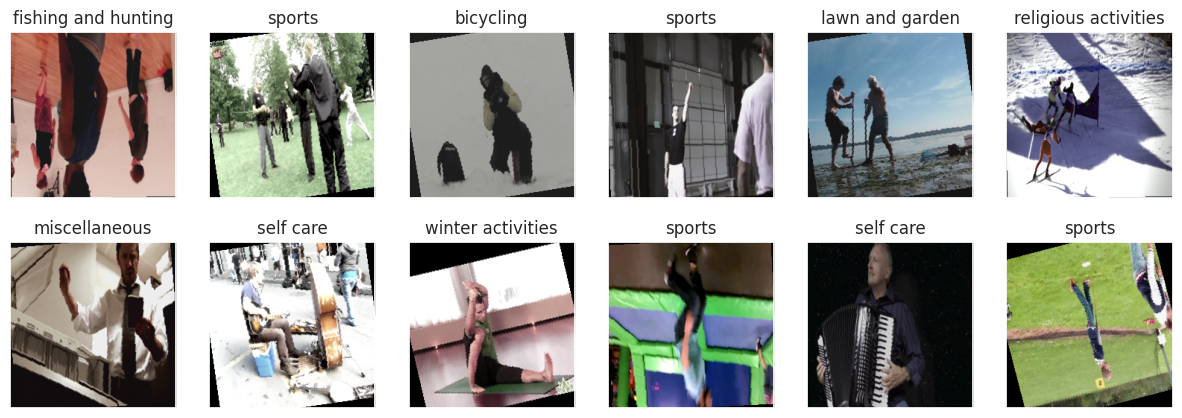

In [26]:
plot_images(train_dataloader) # тут слетели метки классов(

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Выбираем GPU для баффа к скорости
device

device(type='cuda')

# Модели

In [18]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_connetcion = nn.Sequential()
        
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.skip_connetcion = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip_connetcion(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, NUM_CLASSES)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

## ResNet18

In [19]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Суммари модели

In [32]:
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14           [-1, 64,

## Функции Тренеровки/Валидации

In [20]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    total_samples = 0
    processed_batches = 0

    all_preds = []  
    all_labels = [] 

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        inputs, labels = batch  
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        processed_batches += 1

        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    epoch_loss = running_loss / total_samples

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted', zero_division=0)

    return epoch_loss, f1 

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            if batch is None or batch[0] is None or batch[1] is None:
                continue
            inputs, labels = batch 
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            total_samples += labels.size(0)


    epoch_loss = running_loss / total_samples
    f1 = f1_score(all_labels, all_predictions, average='macro', labels=list(range(NUM_CLASSES)), zero_division=0)


    return epoch_loss, f1

## Тренеровка 

In [21]:
def train_model(model, device, train_dataloader, test_dataloader, optimizer, loss_function, scheduler, epochs) :
    print("Начало тренировки")
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []} 
    best_val_f1 = 0.0
    
    if train_dataloader is None or test_dataloader is None:
        print("Ошибка: DataLoader'ы не инициализированы.")
    else:
        for epoch in range(epochs):
            
            train_loss, train_f1 = train_epoch(model, train_dataloader, optimizer, loss_function, device)
    
            
            val_loss, val_f1 = evaluate(model, test_dataloader, loss_function, device)
    
    
            history['train_loss'].append(train_loss)
            history['train_f1'].append(train_f1)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
    
    
            print(f"Эпоха {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f} | Train F1 (Macro): {train_f1:.4f}")
            print(f"  Val Loss:   {val_loss:.4f} | Val F1 (Macro): {val_f1:.4f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}") 
    
    
            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                     scheduler.step(val_f1)
                else:
                     scheduler.step() 
    
    
            if val_f1 > best_val_f1:
                print(f"  F1 улучшился ({best_val_f1:.4f} --> {val_f1:.4f}). Сохраняю модель в {BEST_MODEL_PATH}...")
                best_val_f1 = val_f1
                torch.save(model.state_dict(), BEST_MODEL_PATH)
    
    
        print("Тренеровка завершена!")
        print(f"Лучшая F1 (Macro) на валидации: {best_val_f1:.4f}")
    
    
        if os.path.exists(BEST_MODEL_PATH) and best_val_f1 > 0:
            print(f"Загружаю лучшую модель из {BEST_MODEL_PATH}")
            model.load_state_dict(torch.load(BEST_MODEL_PATH))
        else:
            print("Лучшая модель не сохранена(")

In [ ]:
train_model(model, device, train_dataloader, test_dataloader, optimizer, loss_function, scheduler, NUM_EPOCHS)

## Отображение результатов

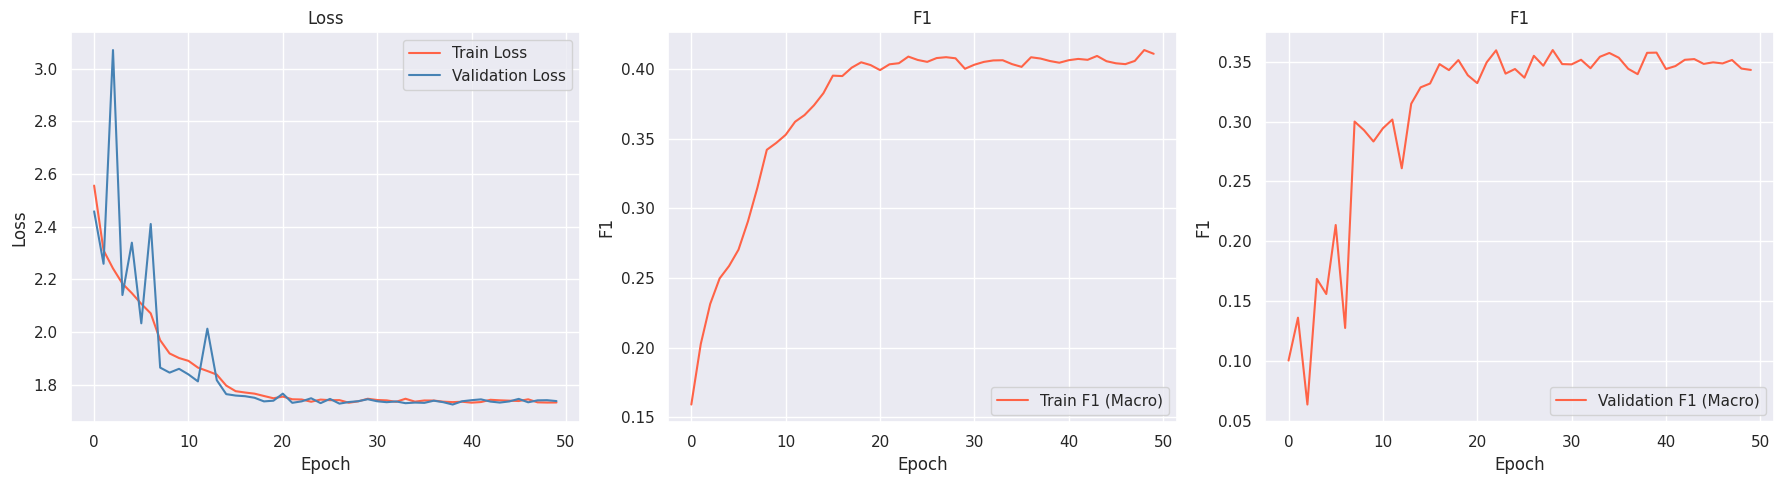

In [24]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.title('F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Validation F1 (Macro)')
plt.title('F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## BottleNeck

In [22]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return torch.relu(out)


### CrocodiloNet

In [30]:
train_dataloader, test_dataloader = train_test(
    TRAIN_IMG_DIR, 
    TRAIN_CSV_PATH,
    train_trans=transform5,
    test_trans=transformSimple3,
    batch_size=48)

In [26]:
crocodiloModel = ResNet(Bottleneck, [2, 3, 4, 3]).to(device)

In [27]:
summary(crocodiloModel, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
       Bottleneck-13          [-1, 256, 56, 56]               0
           Conv2d-14           [-1, 64,

In [28]:
optimizer2 = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [31]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer2, loss_function, scheduler2, NUM_EPOCHS_2)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/100:
  Train Loss: 2.9468 | Train F1 (Macro): 0.0121
  Val Loss:   2.9263 | Val F1 (Macro): 0.0131
  LR: 0.010000
  F1 улучшился (0.0000 --> 0.0131). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/100:
  Train Loss: 2.9467 | Train F1 (Macro): 0.0107
  Val Loss:   2.9254 | Val F1 (Macro): 0.0125
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/100:
  Train Loss: 2.9442 | Train F1 (Macro): 0.0124
  Val Loss:   2.9197 | Val F1 (Macro): 0.0140
  LR: 0.010000
  F1 улучшился (0.0131 --> 0.0140). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/100:
  Train Loss: 2.9471 | Train F1 (Macro): 0.0116
  Val Loss:   2.9280 | Val F1 (Macro): 0.0141
  LR: 0.010000
  F1 улучшился (0.0140 --> 0.0141). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/100:
  Train Loss: 2.9469 | Train F1 (Macro): 0.0112
  Val Loss:   2.9251 | Val F1 (Macro): 0.0131
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/100:
  Train Loss: 2.9444 | Train F1 (Macro): 0.0122
  Val Loss:   2.9328 | Val F1 (Macro): 0.0132
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/100:
  Train Loss: 2.9476 | Train F1 (Macro): 0.0115
  Val Loss:   2.9284 | Val F1 (Macro): 0.0138
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/100:
  Train Loss: 2.9493 | Train F1 (Macro): 0.0121
  Val Loss:   2.9282 | Val F1 (Macro): 0.0115
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/100:
  Train Loss: 2.9435 | Train F1 (Macro): 0.0112
  Val Loss:   2.9232 | Val F1 (Macro): 0.0121
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/100:
  Train Loss: 2.9459 | Train F1 (Macro): 0.0115
  Val Loss:   2.9334 | Val F1 (Macro): 0.0133
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 11/100:
  Train Loss: 2.9461 | Train F1 (Macro): 0.0124
  Val Loss:   2.9219 | Val F1 (Macro): 0.0130
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 12/100:
  Train Loss: 2.9461 | Train F1 (Macro): 0.0117
  Val Loss:   2.9320 | Val F1 (Macro): 0.0111
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 13/100:
  Train Loss: 2.9437 | Train F1 (Macro): 0.0122
  Val Loss:   2.9304 | Val F1 (Macro): 0.0162
  LR: 0.010000
  F1 улучшился (0.0141 --> 0.0162). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 14/100:
  Train Loss: 2.9468 | Train F1 (Macro): 0.0105
  Val Loss:   2.9264 | Val F1 (Macro): 0.0138
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 15/100:
  Train Loss: 2.9437 | Train F1 (Macro): 0.0113
  Val Loss:   2.9254 | Val F1 (Macro): 0.0120
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 16/100:
  Train Loss: 2.9459 | Train F1 (Macro): 0.0113
  Val Loss:   2.9270 | Val F1 (Macro): 0.0127
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 17/100:
  Train Loss: 2.9495 | Train F1 (Macro): 0.0102
  Val Loss:   2.9198 | Val F1 (Macro): 0.0155
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 18/100:
  Train Loss: 2.9475 | Train F1 (Macro): 0.0116
  Val Loss:   2.9299 | Val F1 (Macro): 0.0133
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 19/100:
  Train Loss: 2.9440 | Train F1 (Macro): 0.0123
  Val Loss:   2.9292 | Val F1 (Macro): 0.0148
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 20/100:
  Train Loss: 2.9460 | Train F1 (Macro): 0.0120
  Val Loss:   2.9220 | Val F1 (Macro): 0.0143
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 21/100:
  Train Loss: 2.9480 | Train F1 (Macro): 0.0118
  Val Loss:   2.9306 | Val F1 (Macro): 0.0140
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 22/100:
  Train Loss: 2.9470 | Train F1 (Macro): 0.0114
  Val Loss:   2.9218 | Val F1 (Macro): 0.0150
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 23/100:
  Train Loss: 2.9461 | Train F1 (Macro): 0.0121
  Val Loss:   2.9372 | Val F1 (Macro): 0.0143
  LR: 0.010000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Явное затухание**, что мы можем наблюдать вот уже близ **10-15-х** эпох. Предположительно, связано это с подобранным **LR=0.01** - **завышен**, также стоит опробовать **scheduler** c другими параметрами

In [36]:
crocodiloModel = ResNet(Bottleneck, [2, 3, 4, 3]).to(device)

In [37]:
optimizer3 = torch.optim.AdamW(
    crocodiloModel.parameters(), 
    lr=0.001,
    weight_decay=0.05
)

scheduler3 = torch.optim.lr_scheduler.SequentialLR(
    optimizer2,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer2, start_factor=0.33, total_iters=3),
        torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.5)
    ],
    milestones=[3]
)

### ResNet2

Версия **ResNet** с добавленным **Dropout** в полносвязный слой для предотвращения *переобучения*

In [38]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, NUM_EPOCHS_2)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/100:
  Train Loss: 2.5914 | Train F1 (Macro): 0.1447
  Val Loss:   2.5140 | Val F1 (Macro): 0.0702
  LR: 0.001000
  F1 улучшился (0.0000 --> 0.0702). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/100:
  Train Loss: 2.3909 | Train F1 (Macro): 0.1830
  Val Loss:   2.2841 | Val F1 (Macro): 0.1499
  LR: 0.001000
  F1 улучшился (0.0702 --> 0.1499). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/100:
  Train Loss: 2.3065 | Train F1 (Macro): 0.2035
  Val Loss:   2.6302 | Val F1 (Macro): 0.1013
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/100:
  Train Loss: 2.2953 | Train F1 (Macro): 0.2112
  Val Loss:   2.1932 | Val F1 (Macro): 0.1514
  LR: 0.001000
  F1 улучшился (0.1499 --> 0.1514). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/100:
  Train Loss: 2.2539 | Train F1 (Macro): 0.2219
  Val Loss:   2.1797 | Val F1 (Macro): 0.1487
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/100:
  Train Loss: 2.1800 | Train F1 (Macro): 0.2459
  Val Loss:   2.2770 | Val F1 (Macro): 0.1511
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/100:
  Train Loss: 2.1390 | Train F1 (Macro): 0.2570
  Val Loss:   2.1329 | Val F1 (Macro): 0.1771
  LR: 0.001000
  F1 улучшился (0.1514 --> 0.1771). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/100:
  Train Loss: 2.1066 | Train F1 (Macro): 0.2694
  Val Loss:   2.2791 | Val F1 (Macro): 0.1930
  LR: 0.001000
  F1 улучшился (0.1771 --> 0.1930). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/100:
  Train Loss: 2.0915 | Train F1 (Macro): 0.2743
  Val Loss:   2.1510 | Val F1 (Macro): 0.2052
  LR: 0.001000
  F1 улучшился (0.1930 --> 0.2052). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/100:
  Train Loss: 2.0661 | Train F1 (Macro): 0.2827
  Val Loss:   2.2184 | Val F1 (Macro): 0.1826
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 11/100:
  Train Loss: 2.0316 | Train F1 (Macro): 0.2978
  Val Loss:   2.0501 | Val F1 (Macro): 0.2064
  LR: 0.001000
  F1 улучшился (0.2052 --> 0.2064). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 12/100:
  Train Loss: 1.9955 | Train F1 (Macro): 0.3123
  Val Loss:   2.0529 | Val F1 (Macro): 0.2105
  LR: 0.001000
  F1 улучшился (0.2064 --> 0.2105). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 13/100:
  Train Loss: 1.9789 | Train F1 (Macro): 0.3167
  Val Loss:   2.0050 | Val F1 (Macro): 0.2424
  LR: 0.001000
  F1 улучшился (0.2105 --> 0.2424). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 14/100:
  Train Loss: 1.9366 | Train F1 (Macro): 0.3372
  Val Loss:   1.8788 | Val F1 (Macro): 0.2566
  LR: 0.001000
  F1 улучшился (0.2424 --> 0.2566). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 15/100:
  Train Loss: 1.9110 | Train F1 (Macro): 0.3486
  Val Loss:   1.9789 | Val F1 (Macro): 0.2445
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 16/100:
  Train Loss: 1.8854 | Train F1 (Macro): 0.3515
  Val Loss:   1.9083 | Val F1 (Macro): 0.2639
  LR: 0.001000
  F1 улучшился (0.2566 --> 0.2639). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 17/100:
  Train Loss: 1.8703 | Train F1 (Macro): 0.3575
  Val Loss:   2.0206 | Val F1 (Macro): 0.2687
  LR: 0.001000
  F1 улучшился (0.2639 --> 0.2687). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 18/100:
  Train Loss: 1.8338 | Train F1 (Macro): 0.3685
  Val Loss:   1.8688 | Val F1 (Macro): 0.2912
  LR: 0.001000
  F1 улучшился (0.2687 --> 0.2912). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 19/100:
  Train Loss: 1.8114 | Train F1 (Macro): 0.3791
  Val Loss:   1.7852 | Val F1 (Macro): 0.3029
  LR: 0.001000
  F1 улучшился (0.2912 --> 0.3029). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 20/100:
  Train Loss: 1.7746 | Train F1 (Macro): 0.3970
  Val Loss:   1.8337 | Val F1 (Macro): 0.3036
  LR: 0.001000
  F1 улучшился (0.3029 --> 0.3036). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 21/100:
  Train Loss: 1.7603 | Train F1 (Macro): 0.3972
  Val Loss:   1.8195 | Val F1 (Macro): 0.3227
  LR: 0.001000
  F1 улучшился (0.3036 --> 0.3227). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 22/100:
  Train Loss: 1.7383 | Train F1 (Macro): 0.4062
  Val Loss:   1.7960 | Val F1 (Macro): 0.3239
  LR: 0.001000
  F1 улучшился (0.3227 --> 0.3239). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 23/100:
  Train Loss: 1.7175 | Train F1 (Macro): 0.4168
  Val Loss:   1.8853 | Val F1 (Macro): 0.2735
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 24/100:
  Train Loss: 1.6905 | Train F1 (Macro): 0.4267
  Val Loss:   1.7214 | Val F1 (Macro): 0.3490
  LR: 0.001000
  F1 улучшился (0.3239 --> 0.3490). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 25/100:
  Train Loss: 1.6521 | Train F1 (Macro): 0.4336
  Val Loss:   1.8080 | Val F1 (Macro): 0.3318
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 26/100:
  Train Loss: 1.6378 | Train F1 (Macro): 0.4424
  Val Loss:   1.7935 | Val F1 (Macro): 0.3444
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 27/100:
  Train Loss: 1.6037 | Train F1 (Macro): 0.4587
  Val Loss:   1.6690 | Val F1 (Macro): 0.3751
  LR: 0.001000
  F1 улучшился (0.3490 --> 0.3751). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 28/100:
  Train Loss: 1.5610 | Train F1 (Macro): 0.4736
  Val Loss:   1.7022 | Val F1 (Macro): 0.3632
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 29/100:
  Train Loss: 1.5370 | Train F1 (Macro): 0.4793
  Val Loss:   1.7602 | Val F1 (Macro): 0.3700
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 30/100:
  Train Loss: 1.5174 | Train F1 (Macro): 0.4915
  Val Loss:   1.5970 | Val F1 (Macro): 0.4042
  LR: 0.001000
  F1 улучшился (0.3751 --> 0.4042). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 31/100:
  Train Loss: 1.4707 | Train F1 (Macro): 0.5068
  Val Loss:   1.7177 | Val F1 (Macro): 0.3817
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 32/100:
  Train Loss: 1.4564 | Train F1 (Macro): 0.5092
  Val Loss:   1.6025 | Val F1 (Macro): 0.4118
  LR: 0.001000
  F1 улучшился (0.4042 --> 0.4118). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 33/100:
  Train Loss: 1.3974 | Train F1 (Macro): 0.5315
  Val Loss:   1.5609 | Val F1 (Macro): 0.4414
  LR: 0.001000
  F1 улучшился (0.4118 --> 0.4414). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 34/100:
  Train Loss: 1.4040 | Train F1 (Macro): 0.5256
  Val Loss:   1.5317 | Val F1 (Macro): 0.4353
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 35/100:
  Train Loss: 1.3437 | Train F1 (Macro): 0.5553
  Val Loss:   1.5220 | Val F1 (Macro): 0.4451
  LR: 0.001000
  F1 улучшился (0.4414 --> 0.4451). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 36/100:
  Train Loss: 1.3134 | Train F1 (Macro): 0.5595
  Val Loss:   1.5755 | Val F1 (Macro): 0.4332
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 37/100:
  Train Loss: 1.2745 | Train F1 (Macro): 0.5713
  Val Loss:   1.5631 | Val F1 (Macro): 0.4485
  LR: 0.001000
  F1 улучшился (0.4451 --> 0.4485). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 38/100:
  Train Loss: 1.2386 | Train F1 (Macro): 0.5849
  Val Loss:   1.5911 | Val F1 (Macro): 0.4296
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 39/100:
  Train Loss: 1.2180 | Train F1 (Macro): 0.5925
  Val Loss:   1.5866 | Val F1 (Macro): 0.4359
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 40/100:
  Train Loss: 1.1588 | Train F1 (Macro): 0.6080
  Val Loss:   1.5917 | Val F1 (Macro): 0.4498
  LR: 0.001000
  F1 улучшился (0.4485 --> 0.4498). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 41/100:
  Train Loss: 1.1587 | Train F1 (Macro): 0.6132
  Val Loss:   1.5476 | Val F1 (Macro): 0.4548
  LR: 0.001000
  F1 улучшился (0.4498 --> 0.4548). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 42/100:
  Train Loss: 1.0983 | Train F1 (Macro): 0.6283
  Val Loss:   1.6197 | Val F1 (Macro): 0.4291
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 43/100:
  Train Loss: 1.0666 | Train F1 (Macro): 0.6490
  Val Loss:   1.5153 | Val F1 (Macro): 0.4772
  LR: 0.001000
  F1 улучшился (0.4548 --> 0.4772). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 44/100:
  Train Loss: 1.0225 | Train F1 (Macro): 0.6579
  Val Loss:   1.4970 | Val F1 (Macro): 0.4874
  LR: 0.001000
  F1 улучшился (0.4772 --> 0.4874). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 45/100:
  Train Loss: 1.0208 | Train F1 (Macro): 0.6614
  Val Loss:   1.5770 | Val F1 (Macro): 0.4627
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 46/100:
  Train Loss: 0.9875 | Train F1 (Macro): 0.6711
  Val Loss:   1.4106 | Val F1 (Macro): 0.5036
  LR: 0.001000
  F1 улучшился (0.4874 --> 0.5036). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 47/100:
  Train Loss: 0.9264 | Train F1 (Macro): 0.6875
  Val Loss:   1.4071 | Val F1 (Macro): 0.5310
  LR: 0.001000
  F1 улучшился (0.5036 --> 0.5310). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 48/100:
  Train Loss: 0.9084 | Train F1 (Macro): 0.6964
  Val Loss:   1.5347 | Val F1 (Macro): 0.5020
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 49/100:
  Train Loss: 0.8749 | Train F1 (Macro): 0.7060
  Val Loss:   1.4893 | Val F1 (Macro): 0.5017
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 50/100:
  Train Loss: 0.8425 | Train F1 (Macro): 0.7171
  Val Loss:   1.5494 | Val F1 (Macro): 0.5024
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 51/100:
  Train Loss: 0.8575 | Train F1 (Macro): 0.7147
  Val Loss:   1.5617 | Val F1 (Macro): 0.4795
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 52/100:
  Train Loss: 0.7791 | Train F1 (Macro): 0.7339
  Val Loss:   1.5029 | Val F1 (Macro): 0.5073
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 53/100:
  Train Loss: 0.7451 | Train F1 (Macro): 0.7519
  Val Loss:   1.4755 | Val F1 (Macro): 0.5096
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 54/100:
  Train Loss: 0.7257 | Train F1 (Macro): 0.7555
  Val Loss:   1.4207 | Val F1 (Macro): 0.5419
  LR: 0.001000
  F1 улучшился (0.5310 --> 0.5419). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 55/100:
  Train Loss: 0.6997 | Train F1 (Macro): 0.7674
  Val Loss:   1.4951 | Val F1 (Macro): 0.5251
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 56/100:
  Train Loss: 0.6812 | Train F1 (Macro): 0.7724
  Val Loss:   1.6566 | Val F1 (Macro): 0.5206
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 57/100:
  Train Loss: 0.6553 | Train F1 (Macro): 0.7821
  Val Loss:   1.6629 | Val F1 (Macro): 0.5211
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 58/100:
  Train Loss: 0.6891 | Train F1 (Macro): 0.7680
  Val Loss:   1.5311 | Val F1 (Macro): 0.5381
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 59/100:
  Train Loss: 0.5774 | Train F1 (Macro): 0.8020
  Val Loss:   1.6316 | Val F1 (Macro): 0.5420
  LR: 0.001000
  F1 улучшился (0.5419 --> 0.5420). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 60/100:
  Train Loss: 0.6136 | Train F1 (Macro): 0.7948
  Val Loss:   1.5527 | Val F1 (Macro): 0.5590
  LR: 0.001000
  F1 улучшился (0.5420 --> 0.5590). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 61/100:
  Train Loss: 0.5294 | Train F1 (Macro): 0.8209
  Val Loss:   1.6580 | Val F1 (Macro): 0.5427
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 62/100:
  Train Loss: 0.5212 | Train F1 (Macro): 0.8225
  Val Loss:   1.7248 | Val F1 (Macro): 0.5339
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 63/100:
  Train Loss: 0.5418 | Train F1 (Macro): 0.8221
  Val Loss:   1.5291 | Val F1 (Macro): 0.5679
  LR: 0.001000
  F1 улучшился (0.5590 --> 0.5679). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 64/100:
  Train Loss: 0.4873 | Train F1 (Macro): 0.8370
  Val Loss:   1.5959 | Val F1 (Macro): 0.5502
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 65/100:
  Train Loss: 0.5021 | Train F1 (Macro): 0.8309
  Val Loss:   1.6071 | Val F1 (Macro): 0.5461
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 66/100:
  Train Loss: 0.4382 | Train F1 (Macro): 0.8534
  Val Loss:   1.6231 | Val F1 (Macro): 0.5625
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 67/100:
  Train Loss: 0.4290 | Train F1 (Macro): 0.8508
  Val Loss:   1.8705 | Val F1 (Macro): 0.5409
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 68/100:
  Train Loss: 0.4655 | Train F1 (Macro): 0.8473
  Val Loss:   1.5438 | Val F1 (Macro): 0.5724
  LR: 0.001000
  F1 улучшился (0.5679 --> 0.5724). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 69/100:
  Train Loss: 0.3954 | Train F1 (Macro): 0.8692
  Val Loss:   1.6337 | Val F1 (Macro): 0.5720
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 70/100:
  Train Loss: 0.4237 | Train F1 (Macro): 0.8584
  Val Loss:   1.6157 | Val F1 (Macro): 0.5625
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 71/100:
  Train Loss: 0.3674 | Train F1 (Macro): 0.8750
  Val Loss:   1.6108 | Val F1 (Macro): 0.5763
  LR: 0.001000
  F1 улучшился (0.5724 --> 0.5763). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 72/100:
  Train Loss: 0.3896 | Train F1 (Macro): 0.8703
  Val Loss:   1.5589 | Val F1 (Macro): 0.5810
  LR: 0.001000
  F1 улучшился (0.5763 --> 0.5810). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 73/100:
  Train Loss: 0.3468 | Train F1 (Macro): 0.8845
  Val Loss:   1.8851 | Val F1 (Macro): 0.5330
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 74/100:
  Train Loss: 0.3547 | Train F1 (Macro): 0.8872
  Val Loss:   1.6828 | Val F1 (Macro): 0.5775
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 75/100:
  Train Loss: 0.3058 | Train F1 (Macro): 0.8987
  Val Loss:   1.8456 | Val F1 (Macro): 0.5257
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 76/100:
  Train Loss: 0.3336 | Train F1 (Macro): 0.8902
  Val Loss:   1.7150 | Val F1 (Macro): 0.5538
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 77/100:
  Train Loss: 0.3361 | Train F1 (Macro): 0.8862
  Val Loss:   1.6182 | Val F1 (Macro): 0.5937
  LR: 0.001000
  F1 улучшился (0.5810 --> 0.5937). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 78/100:
  Train Loss: 0.3055 | Train F1 (Macro): 0.8959
  Val Loss:   1.5910 | Val F1 (Macro): 0.5911
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 79/100:
  Train Loss: 0.3245 | Train F1 (Macro): 0.8924
  Val Loss:   1.7584 | Val F1 (Macro): 0.5714
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 80/100:
  Train Loss: 0.3193 | Train F1 (Macro): 0.8930
  Val Loss:   1.7269 | Val F1 (Macro): 0.5692
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 81/100:
  Train Loss: 0.2939 | Train F1 (Macro): 0.9033
  Val Loss:   1.5773 | Val F1 (Macro): 0.5928
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 82/100:
  Train Loss: 0.2260 | Train F1 (Macro): 0.9253
  Val Loss:   1.7958 | Val F1 (Macro): 0.5554
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 83/100:
  Train Loss: 0.2898 | Train F1 (Macro): 0.9036
  Val Loss:   1.8461 | Val F1 (Macro): 0.5492
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 84/100:
  Train Loss: 0.3133 | Train F1 (Macro): 0.8941
  Val Loss:   1.8477 | Val F1 (Macro): 0.5428
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 85/100:
  Train Loss: 0.2582 | Train F1 (Macro): 0.9146
  Val Loss:   1.6672 | Val F1 (Macro): 0.5835
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 86/100:
  Train Loss: 0.2422 | Train F1 (Macro): 0.9218
  Val Loss:   1.6707 | Val F1 (Macro): 0.5912
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 87/100:
  Train Loss: 0.3073 | Train F1 (Macro): 0.8982
  Val Loss:   1.7008 | Val F1 (Macro): 0.5845
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 88/100:
  Train Loss: 0.2054 | Train F1 (Macro): 0.9320
  Val Loss:   1.9386 | Val F1 (Macro): 0.5513
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 89/100:
  Train Loss: 0.2497 | Train F1 (Macro): 0.9174
  Val Loss:   1.9536 | Val F1 (Macro): 0.5357
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 90/100:
  Train Loss: 0.2791 | Train F1 (Macro): 0.9066
  Val Loss:   1.7232 | Val F1 (Macro): 0.5840
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 91/100:
  Train Loss: 0.2283 | Train F1 (Macro): 0.9224
  Val Loss:   1.7553 | Val F1 (Macro): 0.5850
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
torch.save(crocodiloModel.state_dict(), "last_model.pth")

In [ ]:
torch.load(BEST_MODEL_PATH, map_location=device)

In [ ]:
class ResNet2(ResNet):
    def __init__(self, *args, **kwargs) :
        super(self).__init__(*args, **kwargs)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = nn.Dropout(0.2)(out)
        out = self.fc(out)
        return out

### TralaleloNet

## Отправка предсказаний 

In [41]:
class SubmissionImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        all_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        self.file_list = sorted(all_files, key=lambda f: int(os.path.splitext(f)[0]))
        print(f"Тестовые файлы отсортированы численно (найдено {len(self.file_list)}).")


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image_id = os.path.splitext(img_name)[0]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_id


submission_dataset = SubmissionImageDataset(img_dir=TEST_IMG_DIR, transform=transformSimple3)

submission_loader = DataLoader(
    submission_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)



print(f"Загрузка весов модели из {BEST_MODEL_PATH}...")
crocodiloModel.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
print("Веса модели успешно загружены.")


crocodiloModel.eval()
crocodiloModel.to(device)

all_pred_original_labels = []
all_image_ids = []

print("Начало предсказания на тестовых данных...")
with torch.no_grad():
    for image_batch, ids_batch in tqdm(submission_loader, desc="Predicting"):
        if image_batch is None: continue

        image_batch = image_batch.to(device)
        y_pred_logits = crocodiloModel(image_batch)
        y_pred_dense_label = torch.argmax(y_pred_logits, dim=1)
        dense_preds_list = y_pred_dense_label.cpu().tolist()


        original_preds_batch = []
        for dense_pred in dense_preds_list:
             original_pred = dense_to_original_map.get(dense_pred)
             if original_pred is None:
                 original_preds_batch.append(-1)
             else:
                 original_preds_batch.append(original_pred)

        all_pred_original_labels.extend(original_preds_batch)
        all_image_ids.extend(list(ids_batch))

print("Предсказание завершено.")

print(f"Создание DataFrame с {len(all_image_ids)} записями...")
df_preds = pd.DataFrame({
    'id': all_image_ids,
    'target_feature': all_pred_original_labels
})

df_preds['id_int_temp'] = df_preds['id'].astype(int)
df_preds = df_preds.sort_values(by='id_int_temp').drop(columns=['id_int_temp'])
df_preds = df_preds.reset_index(drop=True) 
df_preds.to_csv(SUBMISSION_CSV_PATH, index=False)
print(f"Файл предсказаний успешно сохранен в {SUBMISSION_CSV_PATH}")
print("\nПервые 5 строк файла предсказаний:")
print(df_preds.head())
print("\nУникальные предсказанные метки:")
print(sorted(df_preds['target_feature'].unique()))

Тестовые файлы отсортированы численно (найдено 5301).
Загрузка весов модели из best_model.pth...
Веса модели успешно загружены.
Начало предсказания на тестовых данных...


Predicting:   0%|          | 0/111 [00:00<?, ?it/s]

Предсказание завершено.
Создание DataFrame с 5301 записями...
Файл предсказаний успешно сохранен в submission.csv

Первые 5 строк файла предсказаний:
   id  target_feature
0   0              16
1   3               0
2   5               2
3   8              18
4  14               0

Уникальные предсказанные метки:
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]


In [26]:
!ls

 BasePipeLine.ipynb	      miniconda3
'augi (3).ipynb'	      notebooks
 augi+train+submit.ipynb      submission.csv
 augiыыы.py		      yandex.ipynb
 augmentationResearch.ipynb   Автоэнкодер_ДЗ.ipynb
 best_model.pth		      Задачи_компьютерного_зрения_ДЗ_по_семинару.ipynb
 data
